# Libraries

In [1]:
library(car) # for significance testing of effects in linea rmodels, using the Anova() function
library(emmeans) # for post hoc tests
library(ggfortify) # for nice, easy diagnostic plots

library(tidyverse) # always load last

theme_set(theme_minimal())

Loading required package: ggplot2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.0.3     ✔ purrr   0.3.4
✔ tidyr   1.1.0     ✔ dplyr   0.8.5
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.0.3     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ purrr::some()   masks car::some()


# Correlation

## Basic example

In [ ]:
n = 50
x_mean = 1
x_sd = 0.5

x = rnorm(n, x_mean, x_sd)
y = 1.2 + x + rnorm(n,0, 2*x_sd)

plot(x,y)

cor.test(x,y,) # Pearson, by default

## Spearman's rho correlation coefficient
Suited for monotonic (non necessarily linear) relationships.

In [ ]:
n = 50
x_mean = 1
x_sd = 0.5

x = rnorm(n, x_mean, x_sd)
y = 1.2 + exp(3*x) + rnorm(n,0, 5*x_sd)

plot(x,y)

cor.test(x,y,) # Pearson, by default
cor.test(x,y, method = "spearman")
cor.test(x,y, method = "kendall")

# Simple linear model

## Simulate and visualize data

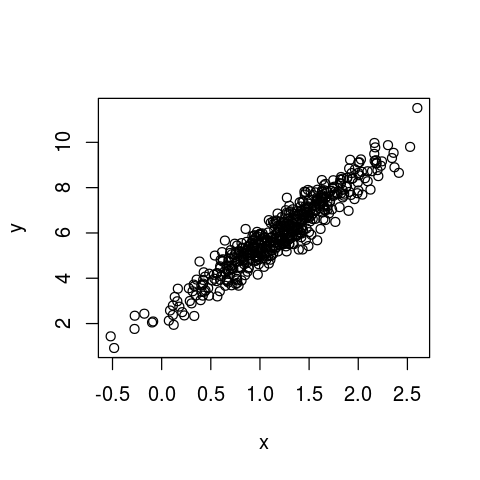

In [3]:
n = 500
x_mean = 1.2
x_sd = 0.5

x = rnorm(n, mean = x_mean, sd = x_sd)
e = rnorm(n, mean = 0, sd = 1*x_sd)
y = 2.4 + 3*x + e

options(repr.plot.width = 4, repr.plot.height = 4)
plot(x,y)

## Regressor coefficients

In [4]:
m <- lm("y ~ x + 1", data = list(x = x, y = y))
m


Call:
lm(formula = "y ~ x + 1", data = list(x = x, y = y))

Coefficients:
(Intercept)            x  
      2.379        3.006  


In [ ]:
# lm() understands column names
m <- lm("predicted ~ regressor + 1", data = list(regressor = x, predicted = y))
m

In [ ]:
# "1" means interpcet in the formula syntax. lm() includes an intercept by default,
# so it is not necessary to specify it
m <- lm("y ~ x", data = list(x = x, y = y))
m

In [ ]:
# It's possible to remove the intercept (by forcing it to 0) but you need a very good a priori reason to do that
m <- lm("y ~ x + 0", data = list(x = x, y = y))
m

In [ ]:
# We can easily obtain confidence intervals for each model parameter
confint(m)

## Comparison to correlation

In [ ]:
n = 100
x_mean = 17.4
x_sd = 4.3

x = rnorm(n, mean = x_mean, sd = x_sd)
e = rnorm(n, mean = 0, sd = 1*x_sd)
y = -8.2 + 1.5*x + e


# The standardized regressor coefficient is equal to the correlation coefficient! 
lm(y ~ x, list(x = scale(x), y = scale(y)))
cor(x,y)

# Fitting linear models

## Diagnostics

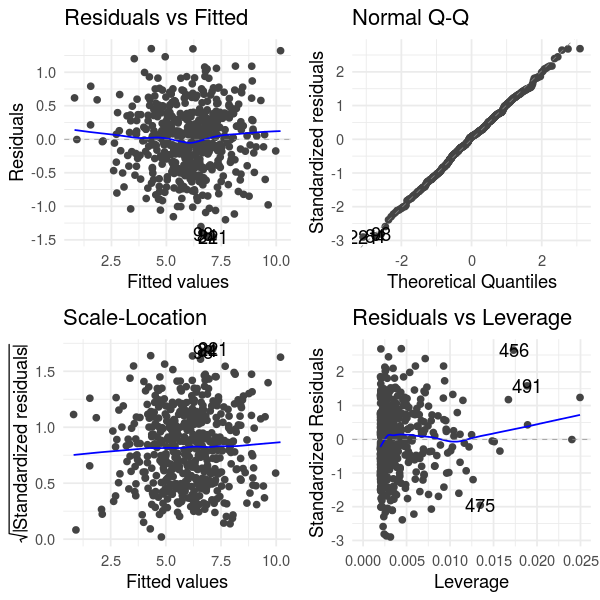

In [5]:
m <- lm("y ~ x", data = list(x = x, y = y))

options(repr.plot.width = 5, repr.plot.height = 5)
autoplot(m) # convenient function for diagnostic plot, from the ggfotify library

## summary()

In [7]:
m <- lm("x ~ y", data = list(x = x, y = y))
summary(m)


Call:
lm(formula = "y ~ x")

Residuals:
     Min       1Q   Median       3Q      Max 
-1.45749 -0.34505  0.03578  0.34476  1.35157 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.37861    0.05784   41.12   <2e-16 ***
x            3.00567    0.04444   67.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5039 on 498 degrees of freedom
Multiple R-squared:  0.9018,	Adjusted R-squared:  0.9016 
F-statistic:  4575 on 1 and 498 DF,  p-value: < 2.2e-16


In [ ]:
# The R-squared of the regression is the percentage of variance retained by the regressors,
# the rest of variance is in the residuals.
# As the name suggests, it is the square of the correlation coefficient:
cor.test(x, y)$estimate^2
summary(m)$r.squared

In [ ]:
# Let's examine residuals
hist(m$residuals) # they should be normally distributed
sd(m$residuals)

## Categorical predictors using dummy variables

In [6]:
dummy <- data.frame(d1 = c(0,1,0), d2 = c(0,0,1))
row.names(dummy) <- c("A","B","C") 

dummy

d1 d2
A 0  0 
B 1  0 
C 0  1

In [ ]:
df <- ToothGrowth %>% mutate(dose = as.factor(dose))

# Add dummy variables to the data frame
df.dummy <- df  %>%
    mutate(d1 = map_dbl(dose, .f=function(x){if (x==0.5){0} else if (x==1){1} else if (x==2){0}})) %>% 
    mutate(d2 = map_dbl(dose, .f=function(x){if (x==0.5){0} else if (x==1){0} else if (x==2){1}})) #%>% print()
# df.dummy

In [ ]:
m <- lm(len ~ supp + dose, data = df) # fitting parameter
summary(m) # significance testing

m.dummy <- lm(len ~ supp + d1 + d2, data = df.dummy)
summary(m.dummy)

## Interaction terms

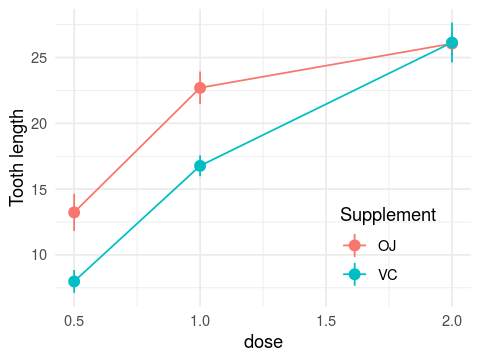

In [5]:
df <- ToothGrowth

options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(df, aes(x = dose, y = len, color = supp)) +
stat_summary(fun.data = mean_se) +
geom_line(data = df %>% group_by(supp,dose) %>% summarise(len = mean(len,na.rm=T)),
          aes(group = supp)) +
labs(y = "Tooth length", color = "Supplement") +
theme(legend.position = c(.8,.2))


In [ ]:
# "*" means : main effects + interactions
m <- lm(len ~ supp + dose + supp:dose, data = df)
Anova(m)

m <- lm(len ~ supp * dose, data = df)
Anova(m) # we expect the exact same results as the previous model 

# Significance testing

## summary() vs. Anova()

In [ ]:
df <- ToothGrowth %>% mutate(dose = as.factor(dose))

m <- lm(len ~ supp + dose, data = df)
summary(m)
Anova(m)

## Post hoc tests

In [ ]:
df <- ToothGrowth %>% mutate(dose = as.factor(dose))

m <- lm(len ~ supp * dose, data = df)

In [ ]:
# Obtain the predicted values from the model ("estimated marginal means"), along with 95% CI
# - for each level of "dose", averaged across levels of "supp"
emmeans(m, "dose")
emmeans(m, ~ dose) # alternative syntax
# - for each experimental cell
emmeans(m, c("dose","supp"))
emmeans(m, ~ dose*supp) # alternative syntax

In [ ]:
# Change the confidence level
emmeans(m, ~ dose, level = .90)

In [ ]:
# Pairwise comparisons between levels can be done in multiple ways
# - syntax 1
emmeans(m, pairwise ~ dose|supp)$contrasts 

In [ ]:
# - syntax 2
emmeans(m, ~ dose|supp, contr = "pairwise")$contrasts

In [ ]:
# - syntax 3
emm <- emmeans(m, ~ dose|supp)
pairs(emm)

In [ ]:
# To obtain CIs of contrasts along with p values
pairs(emmeans(m, ~ dose|supp), infer = c(T,T))

In [ ]:
# From the dose contrasts above, it seems that the difference between a dose of 0.5 and a dose of 1
# is very similar in both supplements, while th difference between other pairs of doses is stronger
# with the Vitamin C compared to Orange Juice. Let's this directly using a contrast of contrast
# ( = double difference test):

emm <- emmeans(m,  ~ dose*supp)
contrast(emm, interaction = "pairwise")

# Common tests are linear models

## Independent two-sample t-test

In [ ]:
# Simulate data
n = 40
x1 = rnorm(40, 0, 1)
x2 = rnorm(40, 0.2, 1)

# --- for the linear model
y = c(x1,x2)
group = c(rep("A",n),rep("B",n)) # categorical variable (predictor)

# T-test
t <- t.test(x2,x1, paired=F)

# Linear model
m <- lm(y ~ group)

In [ ]:
# Show results
t
summary(m)

In [ ]:
# Compare CIs
t$conf.int
confint(m)

In [ ]:
# Compare p values
t$p.value
m$

**Converta this notebook to R markdown**

In [11]:
library(rmarkdown)
input = "1-05.ipynb"
rmarkdown:::convert_ipynb(input, output = xfun::with_ext(input, "Rmd"))